In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gpaw import GPAW
from ase.io import read
from abtem import *

Nonetheless, due to recent improvements in microscopes, interest in going beyond this approximation have started. For example, it has been shown that simulated images based on potentials from DFT calculations can provide a better match with experimental data for light elements. This will be investigated later in this tutorial.

In [3]:
atoms = read('graphene_hexagonal.cif')

The unit cell for the DFT calculation does not have to be orthogonal, however, the potential has to be made orthogonal. If the `orthogonalize_cell` raises an error abTEM is not able to use the DFT calculation.

We will use the minimal hexagonal cell for our graphene DFT calculation.

In [4]:
gpaw = GPAW(h=.1, txt=None, kpts=(4,4,4))
atoms.set_calculator(gpaw)
atoms.get_potential_energy()

-18.468420217107088

In [5]:
gpaw.write('graphene.gpw')

In [19]:
gpaw = GPAW('graphene.gpw', txt=None)

In [20]:
dft_potential = GPAWPotential(gpaw, sampling=.02)


In [21]:
dft_potential = dft_potential.build()

dft_potential = dft_potential.tile((3,2))

## Comparing DFT to IAM

In [24]:
from abtem.structures import orthogonalize_cell
atoms = orthogonalize_cell(gpaw.atoms) * (3,2,1)

iam_potential = Potential(atoms, gpts=dft_potential.gpts, cutoff_tolerance=1e-4).build()

In [25]:
projected_iam = iam_potential.array.sum(0)
projected_iam -= projected_iam.min()

projected_dft = dft_potential.array.sum(0)
projected_dft -= projected_dft.min()

absolute_difference = projected_iam - projected_dft

valid = np.abs(projected_iam) > 1
relative_difference = np.zeros_like(projected_iam)
relative_difference[:] = np.nan
relative_difference[valid] = (projected_iam[valid] - projected_dft[valid]) / projected_iam[valid]

[autoreload of abtem.potentials failed: Traceback (most recent call last):
  File "/Users/jacobmadsen/anaconda3/envs/abtem/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/jacobmadsen/anaconda3/envs/abtem/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/jacobmadsen/anaconda3/envs/abtem/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/jacobmadsen/anaconda3/envs/abtem/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/Users/jacobmadsen/anaconda3/envs/abtem/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/Users/jacobmadsen/anaconda3/envs/abtem/lib/python

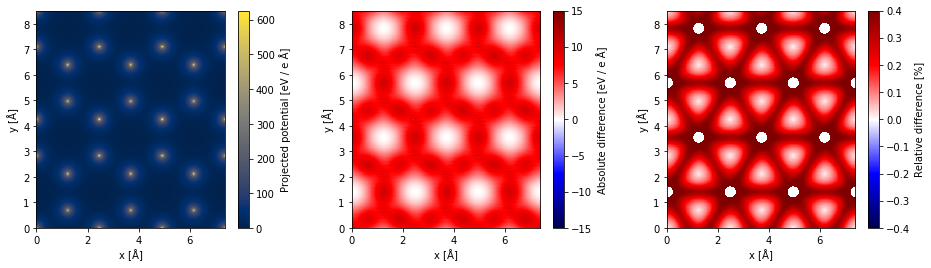

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

extent = [0, dft_potential.extent[0], 0, dft_potential.extent[1]]

im1 = ax1.imshow(projected_dft.T, cmap='cividis', extent=extent)
im2 = ax2.imshow(absolute_difference.T, vmin=-15, vmax=15, cmap='seismic', extent=extent)
im3 = ax3.imshow(relative_difference.T, vmin=-.4, vmax=.4, cmap='seismic', extent=extent)

labels = ('Projected potential [eV / e Å]', 'Absolute difference [eV / e Å]', 'Relative difference [%]')

for ax, im, label in zip((ax1, ax2, ax3), (im1, im2, im3), labels):
    ax.set_xlabel('x [Å]')
    ax.set_ylabel('y [Å]')
    
    fig.colorbar(im, ax=ax, label=label)